<a href="https://colab.research.google.com/github/gsilsbe/Missouri_Reservoirs/blob/main/create_MU_waterbody_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
!pip install rtree
import rtree
import json

from shapely import geometry, ops
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry.multipolygon import MultiPolygon
from shapely.ops import cascaded_union
from shapely.ops import unary_union

from shapely import intersection
from shapely import intersects
from shapely import concave_hull
from shapely import difference, within, contains
import os

Index(['geometry', 'FID', 'TBLE_NAME', 'NHD', 'METADATA', 'STNDRD_ID',
       'WBID_TXT', 'WATER_BODY', 'WB_CLS', 'DS_COUNTY', 'US_COUNTY', 'HUC_8',
       'SIZE_', 'UNIT', 'LEGAL_DS', 'AQL_USE', 'CDF_USE', 'DWS_USE', 'IND_USE',
       'IRR_USE', 'LWW_USE', 'SCR_USE', 'WBCA_USE', 'WBCB_USE', 'HHP_USE',
       'NNC', 'PERM_ID', 'REACHCODE', 'Shape__Area', 'Shape__Length'],
      dtype='object')

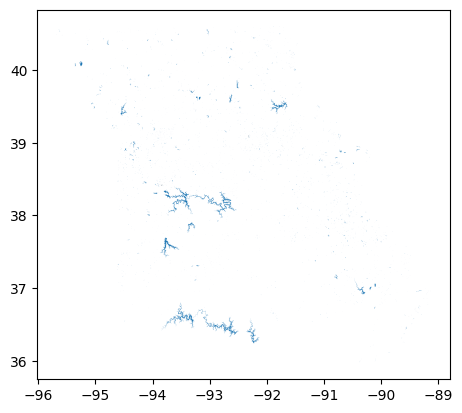

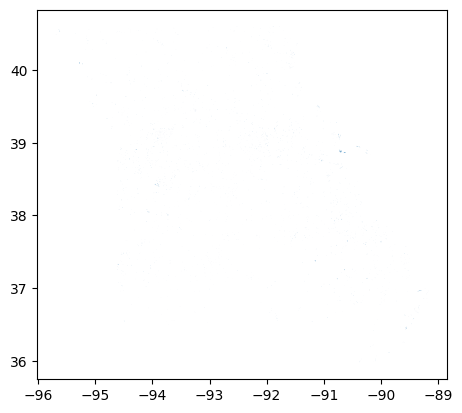

In [ ]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

MO_DNR = gpd.read_file("MO_2020_WQS_Lake_Classification_and_Use.geojson", driver='GeoJSON')
MO_DNR = MO_DNR.drop(columns="EVENTDAT").drop(columns="REACHSMDAT").round(0)
MO_DNR_7630 = MO_DNR[MO_DNR["WATER_BODY"] =="100K Extent-Remaining Lakes"]
MO_DNR = MO_DNR.to_crs(crs=4326)
MO_DNR_7630 = MO_DNR_7630.to_crs(crs=4326)
MO_DNR = MO_DNR.dissolve(by="WBID")
# Plot
MO_DNR.plot()
MO_DNR_7630.plot()

# Column names
MO_DNR.keys()

## Read in MU data, convert lat lon columns to geometry

Index(['waterBodyID', 'WBID', 'MULakeNumber', 'waterBody', 'WATER_BODY_DNR',
       'waterBodyLatitude', 'waterBodyLongitude', 'ecoregionID', 'damHeightM',
       'volumeM3', 'surfAreaHA', 'watershedAreaHA', 'geometry'],
      dtype='object')

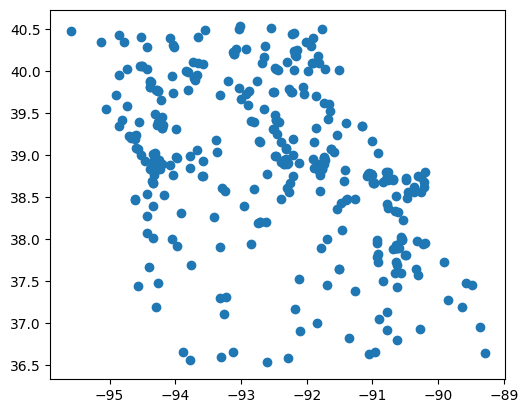

In [ ]:
MU = pd.read_csv('MU_v_DNR.csv')
MU = MU[MU['stateID']==29]
MU = MU.drop(columns="Distance").drop(columns="waterBodyDesc").drop(columns="countyID").drop(columns="countryID").drop(columns="stateID").drop(columns="waterBodyTypeID").drop(columns="MDNRNameID").drop(columns="primarySLAP19").drop(columns="notes").drop(columns="geometry")
MU_gdf = gpd.GeoDataFrame(MU, geometry=gpd.points_from_xy(MU.waterBodyLongitude, MU.waterBodyLatitude) ).set_crs(4326)
MU_gdf = MU_gdf.to_crs(crs=4326)
MU_gdf["WBID"] = MU_gdf["WBID"].fillna(0).astype(int) # convert just column WBID to integer
MU_gdf.plot()
MU_gdf.keys()

In [ ]:
MO_DNR.index

Int64Index([7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010,
            ...
            7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690],
           dtype='int64', name='WBID', length=549)

## Find nearest WaterBody

In [ ]:
for i in range(0,len(MU_gdf)):

  if MU_gdf.iloc[i]["WBID"] ==7630: # Gets geometry of closest WBID 7630
    distances = np.zeros(len(MO_DNR))
    for j in range(0, len(MO_DNR)):
        distances[j] = MU_gdf.iloc[i].geometry.distance(MO_DNR_7630.iloc[j].geometry.centroid)
    idx = np.argmin(distances)
    MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] =  MO_DNR_7630.iloc[idx].geometry

  # Take shapefile from DNR
  elif MU_gdf.iloc[i]['WBID']!=0: # Gets geometry based on WBID
    idx = MU_gdf.iloc[i]['WBID']
    MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] = MO_DNR.loc[idx].geometry
    if MO_DNR.loc[idx].geometry.geom_type == 'MultiPolygon':
      MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] = max(MO_DNR.loc[idx].geometry.geoms, key=lambda a: a.area)
    else:
      MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] = MO_DNR.loc[idx].geometry
 # Looks for gee generated MU.geojson
  else:
    if os.path.exists(str(MU_gdf.iloc[i]["MULakeNumber"]) + '.geojson'):
      gee_gdf = gpd.read_file(str(MU_gdf.iloc[i]["MULakeNumber"]) + '.geojson', driver='GeoJSON')
      if len(gee_gdf) > 1:
        MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[gee_gdf.area.idxmax()].geometry
      else:
        MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] = gee_gdf.geometry


<ipython-input-95-7241eed4b791>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[gee_gdf.area.idxmax()].geometry
<ipython-input-95-7241eed4b791>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[gee_gdf.area.idxmax()].geometry
<ipython-input-95-7241eed4b791>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[gee_gdf.area.idxmax()].geometry
<ipython-input-95-7241eed4b791>:23: UserWarning: Geo

## Insert GEE Shapefiles testing

In [ ]:
MU_gdf #.plot()

,waterBodyID,WBID,MULakeNumber,waterBody,WATER_BODY_DNR,waterBodyLatitude,waterBodyLongitude,ecoregionID,damHeightM,volumeM3,surfAreaHA,watershedAreaHA,geometry
0,1,7177,1,Glover,Glover Spring Lake,38.8476,-91.8876,2.0,10.1,460088.0,7.8,1489.0,"POLYGON ((-91.89507 38.84874, -91.89504 38.848..."
1,2,7249,2,Pinnacle,Pinnacle Lake,38.8258,-91.4197,2.0,14.9,3066431.0,38.4,1900.1,"POLYGON ((-91.42700 38.83779, -91.42684 38.837..."
2,3,7004,3,Bowling Green (East),Bowling Green Reservoir,39.3416,-91.1530,2.0,22.3,1739207.0,8.9,337.0,"POLYGON ((-91.15031 39.33291, -91.15041 39.332..."
3,4,7003,4,Bowling Green (West),Old Lake,39.3423,-91.1611,2.0,18.6,1303788.0,18.2,10.3,"POLYGON ((-91.16047 39.34390, -91.16043 39.343..."
4,5,7049,5,Lincoln,Lake Lincoln,39.0203,-90.9217,2.0,21.0,1894625.0,12.8,404.2,"POLYGON ((-90.91775 39.03182, -90.91773 39.031..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,370,7253,461,See Tal,See Tal Lake,38.6881,-91.4368,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-91.43584 38.68555, -91.43596 38.685..."
354,371,0,462,Tilles Park,NaN,38.6222,-90.3636,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-90.36315 38.62298, -90.36315 38.622..."
355,372,7181,463,McKee Pond,Lake Champetra,38.6710,-92.2592,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-92.24024 38.68021, -92.24041 38.680..."
356,373,0,464,Cedar (Randolph),Rothwell Lake,39.3925,-92.4234,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-92.42335 39.39247, -92.42317 39.392..."


In [ ]:
# Saving a geojson file

# First converts the GeoDataFrame to a JSON string
MU_gdf.to_file("MU.geojson", driver='GeoJSON')
json_string = MU_gdf.to_json(na="drop")

# Then, it opens a file called data.json for writing and uses the json.dump() function to write the JSON string to the file
with open("MU_geo.json", "w") as f:
    json.dump(json_string, f)

In [ ]:
# Saving as csv
pd.DataFrame(MU_gdf).to_csv("MU geometry.csv")

<Axes: >

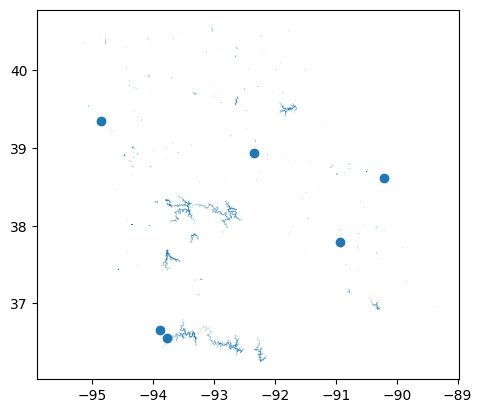

In [ ]:
MU_gdf.plot()

In [ ]:
# iloc method uses an integer indexing
# loc method supports both integer and label-based indexing

MO_WATERBODY = MO_DNR.loc[idx]['WATER_BODY']
MO_WBID = MO_DNR.loc[idx]['WBID']
MO_WATERBODY.index = MU_gdf.index
MO_WBID.index = MU_gdf.index
distance = pd.Series(distance, index =  MU_gdf.index)

final_MU = pd.concat([MU_gdf, MO_WATERBODY, MO_WBID, distance], axis=1)
#final_MU.to_csv("MU_v_DNR.csv")
final_MU

In [ ]:
final_MU

In [ ]:
idx1 = np.argmin(distance_to_shore, axis=1)
idx2 = np.argmax(within_boolean, axis=1)
idx = idx2
np.copyto(idx, idx1, where=idx== 0)
print(idx)

In [ ]:
DNR_WATER_BODY = MO_DNR.iloc[idx]['WATER_BODY']
DNR_WATER_BODY.index = geo_df.index
DNR_FID = MO_DNR.iloc[idx]['FID']
DNR_FID.index = geo_df.index
DNR_STNDRD_ID = MO_DNR.iloc[idx]['STNDRD_ID']
DNR_STNDRD_ID.index = geo_df.index
DNR_Area = MO_DNR.iloc[idx]['Shape__Area']
DNR_Area.index = geo_df.index
DNR_Length = MO_DNR.iloc[idx]['Shape__Length']
DNR_Length.index = geo_df.index
DNR_HUC_8 = MO_DNR.iloc[idx]['HUC_8']
DNR_HUC_8.index = geo_df.index

final_MU_DNR = pd.concat([geo_df, DNR_WATER_BODY, DNR_FID, DNR_STNDRD_ID, DNR_Area,DNR_Length,DNR_HUC_8], axis=1)
final_MU_DNR.to_csv("MU DNR.csv")